In [6]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

import gym
from gym.spaces import Discrete
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.double_q_agent import DoubleQAgent
from source.utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


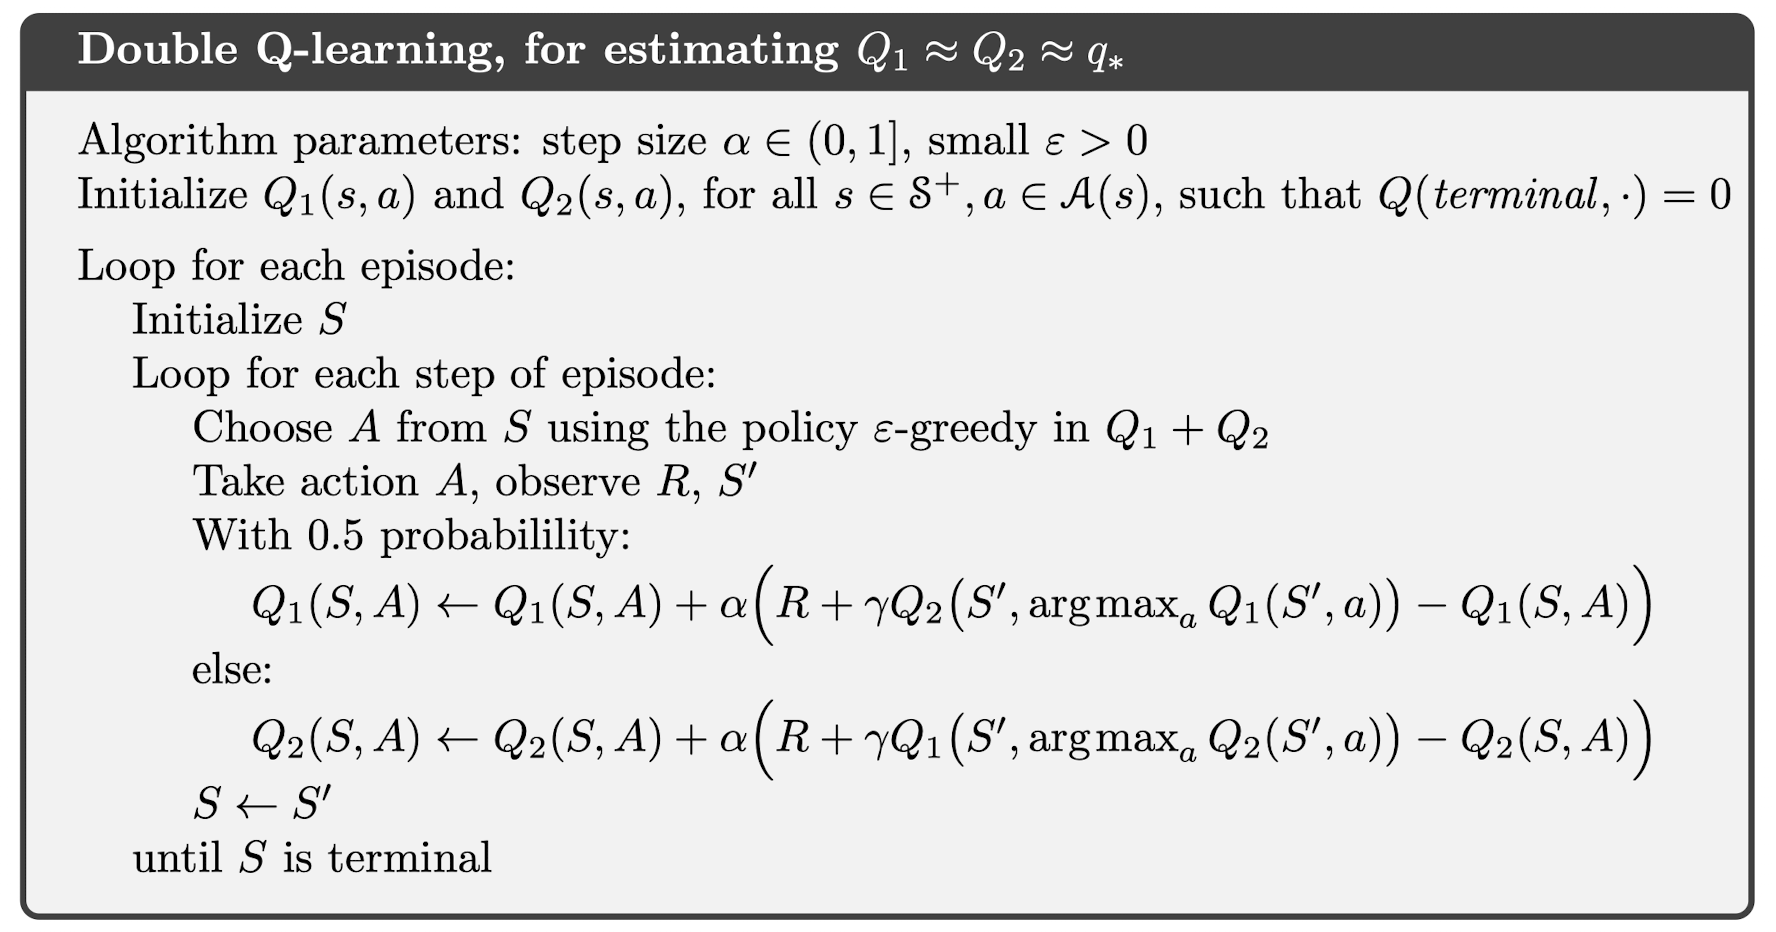

step: 1000, epsilon: 0.65230169730996, total reward: 54.0, avarge success rate: 0.054, avarage reward per step: 0.004977797793889747
step: 2000, epsilon: 0.4727750047927273, total reward: 89.0, avarge success rate: 0.035, avarage reward per step: 0.0028065040979270996
step: 3000, epsilon: 0.3426577089689116, total reward: 148.0, avarge success rate: 0.059, avarage reward per step: 0.004818596660701923
step: 4000, epsilon: 0.2483513390630704, total reward: 201.0, avarge success rate: 0.053, avarage reward per step: 0.004390979094505814
step: 5000, epsilon: 0.18000000000004682, total reward: 261.0, avarge success rate: 0.06, avarage reward per step: 0.004936982262005251
step: 6000, epsilon: 0.13046033946202593, total reward: 316.0, avarge success rate: 0.055, avarage reward per step: 0.004545850430781759
step: 7000, epsilon: 0.09455500095857006, total reward: 367.0, avarge success rate: 0.051, avarage reward per step: 0.004321560037587535
step: 8000, epsilon: 0.06853154179380015, total r

100%|██████████| 1000/1000 [00:01<00:00, 821.49it/s]


Success rate = 0.54
Moviepy - Building video ../../video/double_q.mp4.
Moviepy - Writing video ../../video/double_q.mp4



Moviepy - Done !
Moviepy - video ready ../../video/double_q.mp4


../../video/double_q.mp4


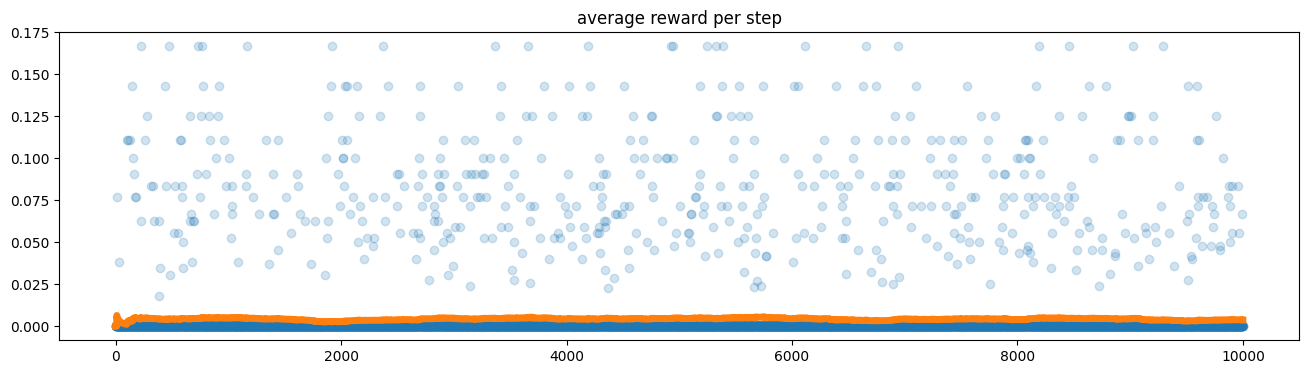

: 

In [12]:
# Policy Eval
# Params
max_episode = 10000
video_path = os.path.join(ROOT, "video/double_q.mp4")
random_seed = 101

# Initialize
history = []
total_reward = 0
report_interval = max_episode // 10
# set random seeds
rng = np.random.default_rng(random_seed)
np.random.seed(random_seed)
# epsilon decay
epsilon_schedule = create_decay_schedule(max_episode)
lr_schedule = create_decay_schedule(max_episode)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4",
               is_slippery=True, render_mode='rgb_array')
env.np_random = rng

# Create Agent
agent = DoubleQAgent(
  state_space=env.observation_space, 
  action_space=env.action_space, 
  discount_rate=0.9,
  epsilon=0.3,
  learning_rate=0.5
)
# Start Learning
for i in range(max_episode):
    reward, steps = agent.play_episode(env)#, epsilon=epsilon_schedule[i])
    history.append(reward / steps)
    total_reward += reward
    if i % report_interval == 0 and i != 0:
        print(
            f"step: {i}, epsilon: {epsilon_schedule[i]}, total reward: {total_reward}, avarge success rate: {np.sum([x > 0 for x in history[-report_interval:-1]])/report_interval}, avarage reward per step: {np.mean(history[-report_interval:-1])}")
print(f"\nrewarding episodes: {total_reward}")

# For off policy learning only: get greedy policy (no exploration)
agent._policy = get_epsilon_greedy_policy_from_action_values(agent._Q1+agent._Q2)
# Run Eval
success_rate = estimate_success_rate(agent, env, 1000)
print(f"Success rate = {success_rate}")
# play last episode with video recording
agent.play_episode(env, learning=False, video_path=video_path)

plot_history(history)
print(video_path)
html=render_mp4(video_path)
HTML(html)


# Summary

## Tempro Difference Off-policy learning
The advantage of off policy learning is that the target policy is different from behavior policy. For TD:
1. Target policy is implicitly represented by action values `_Q`
2. Behavior policy is calcualted by applying epsilon greedy on action values `_Q`

The learned action-value function, `_Q`, directly approximates `q*`, the optimal action-value function, independent of the policy being followed. 

### Q-Learning
Q-learning use `R + max_a(Q(next_state, a)` to represent the future returns, which is independent of the policy being followed.

### Expected Sarsa
Q-learning use `R + E_a(Q(next_state, a)`(where `a` can follow any policy) to represent the future returns.



> Is Expected Sarsa considered off-policy?

> Expected SARSA can be used either on-policy or off-policy. The policy used in the update step determines which it is. If the update step uses a different weighting(target policy) for action choices than the policy that actually took the action(behavior policy), then you are using Expected SARSA in an off-policy way.

> Q-learning is a special case of Expected SARSA, where the target policy is greedy with respect to the action values, so there is only ever one 𝑟𝑡+1+𝛾max𝑎′𝑄(𝑠𝑡+1,𝑎′) term to add with a probability 1.

> link: https://ai.stackexchange.com/questions/20419/is-expected-sarsa-an-off-policy-or-on-policy-algorithm#:~:text=Expected%20SARSA%20can%20be%20used,in%20an%20off%2Dpolicy%20way. 



